In [1]:
%pylab inline
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv
import pandas as pd
# Numpy lets us work with arrays
import numpy as np
# Sklearn provides various modules with a common API
from sklearn import svm, tree, neighbors, neural_network, linear_model, ensemble
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, make_scorer, matthews_corrcoef
# required for OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, validation_curve

# scipy stat library
from scipy.stats import wilcoxon

# visualization library
import seaborn as sns

# import pickle
import pickle

# other models
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost import XGBClassifier

# model tuning
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

# turn off warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('train.csv').set_index("PassengerId")
test_data = pd.read_csv('test.csv').set_index("PassengerId")

In [3]:
# We can use .head() to get just the first few rows of the data.
train_data.head()
# Note how the notebook nicely displays the output for us

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
test_data.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<AxesSubplot:ylabel='PassengerId'>

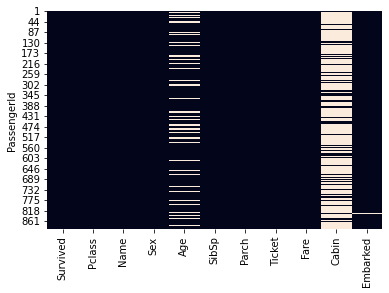

In [5]:
train_data.columns[train_data.isna().any()].tolist()
# visualization of missing values
sns.heatmap(train_data.isnull(),cbar=False)

In [6]:
def parse_title(df):
    # title
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df.Name.str.split(',').str[1].str.split('.').str[0].str.strip()
    df['Title'] = df['Title'].replace('Ms','Miss')
    df['Title'] = df['Title'].replace('Mlle','Miss')
    df['Title'] = df['Title'].replace('Mme','Mrs')
    return df

def process_name(df):
    # parse title first
    df = parse_title(df)
    df['LastName'] = df.Name.str.split(',').str[0]
    # get information about sex from title
    df['IsWomanOrBoy'] = (df.Title == 'Master') | (df.Sex == 'female')
    return df

def add_family_info(df):
    family = df.groupby(df.LastName).Survived
    df['WomanOrBoyCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).count())
    # not working -> columns must be same size as key
    print(df.IsWomanOrBoy.shape, df.WomanOrBoyCount.shape)
    # fix nans
    # df.mask(df.IsWomanOrBoy, df.WomanOrBoyCount, axis=0, inplace=True)
    df['FamilySurvivedCount'] = family.transform(lambda s: s[df.IsWomanOrBoy].fillna(0).sum())
    # df['FamilySurvivedCount'] = df.mask(df.IsWomanOrBoy, df.FamilySurvivedCount - df.Survived.fillna(0), axis=0, inplace=True)
    df['WomanOrBoySurvived'] = df.FamilySurvivedCount / df.WomanOrBoyCount.replace(0, np.nan)
    df.WomanOrBoyCount = df.WomanOrBoyCount.replace(np.nan, 0)
    df['Alone'] = (df.WomanOrBoyCount == 0)


    # Family_Size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    df['Single'] = df['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    df['SmallF'] = df['FamilySize'].map(lambda s: 1 if  s == 2  else 0)
    df['MedF'] = df['FamilySize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
    df['LargeF'] = df['FamilySize'].map(lambda s: 1 if s >= 5 else 0)
    df.drop(columns = ['FamilySize'], inplace=True)
    return df

def fill_missing(df):
    # Embarked
    df['Embarked'] = df['Embarked'].fillna('S')
    # Cabin, Deck
    df['Deck'] = df['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
    df.loc[(df['Deck'] == 'T'), 'Deck'] = 'A'
    # propogate median fair
    med_fare = df.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
    df['Fare'] = df['Fare'].fillna(med_fare)
    #Age
    df['Age'] = df.groupby(['Sex', 'Pclass', 'Title'])['Age'].apply(lambda x: x.fillna(x.median()))
    # family info
    df.WomanOrBoySurvived = df.WomanOrBoySurvived.fillna(0)
    df.WomanOrBoyCount = df.WomanOrBoyCount.fillna(0)
    df.FamilySurvivedCount = df.FamilySurvivedCount.fillna(0)
    df.Alone = df.Alone.fillna(0)
    return df    

In [7]:
'''
transformer = make_column_transformer(
    (OneHotEncoder(), ['island']),
    remainder='passthrough')

transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names()
)
'''
def encode_types(df):
    numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    categorical_columns = []
    features = df.columns.values.tolist()
    for col in features:
        if df[col].dtype in numerics: continue
        categorical_columns.append(col)
    # Encode categorical features to numeric
    # want to use OneHotEncoder
    for col in categorical_columns:
#         if col in df.columns:
#             try:
#                 transformer = make_column_transformer(
#                     (OneHotEncoder(), [col]),
#                     remainder='passthrough')
#                 transformed = transformer.fit_transform(df)
#                 transformed_df = pd.DataFrame(
#                     transformed, 
#                     columns=transformer.get_feature_names()
#                 )
#                 print(df)
#             except:
#                 print("Error transforming")
            le = LabelEncoder()
            le.fit(list(df[col].astype(str).values))
            df[col] = le.transform(list(df[col].astype(str).values))
            
    return df

# not black boxed bu tdoes same as MaxAbScaler from sklearn
def maximum_absolute_scaling(df):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in df_scaled.columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled

def max_abs(df):
    # create an abs_scaler object
    abs_scaler = MaxAbsScaler()
    # calculate the maximum absolute value for scaling the data using the fit method
    abs_scaler.fit(df)
    # the maximum absolute values calculated by the fit method
    print("Max abs value:", abs_scaler.max_abs_)
    # transform the data using the parameters calculated by the fit method (the maximum absolute values)
    scaled_data = abs_scaler.transform(df)
    # store the results in a data frame
    df_scaled = pd.DataFrame(scaled_data, columns=df.columns)
    # visualize the data frame
    return df_scaled
    

In [8]:
RANDOM_SEED = 10

# combine train and test into single df for preprocessing --> becareful bc test won't have survived column
df = pd.concat([train_data, test_data], axis=0, sort=False)
df.head()

df = process_name(df)
print(df)

df = add_family_info(df)

# fill in missing
df = fill_missing(df)

# drop these columns
cols_to_drop = ['Name','Ticket','Cabin']
df = df.drop(cols_to_drop, axis=1)

# encode the string datatypes using LabelEncoder
df = encode_types(df)

# normalize using max abs scaler
df = maximum_absolute_scaling(df)

# separate into data and survived label
train_data, test_data = df.loc[train_data.index], df.loc[test_data.index]
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']

test_data = test_data.loc[:, test_data.columns != 'Survived']
print(test_data.head())

# try kfold from scikit-learn
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_SEED)

# print(X_train.head())
# print(y_train.head())
# print(test_data.head())

             Survived  Pclass  \
PassengerId                     
1                 0.0       3   
2                 1.0       1   
3                 1.0       3   
4                 1.0       1   
5                 0.0       3   
...               ...     ...   
1305              NaN       3   
1306              NaN       1   
1307              NaN       3   
1308              NaN       3   
1309              NaN       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   
...       

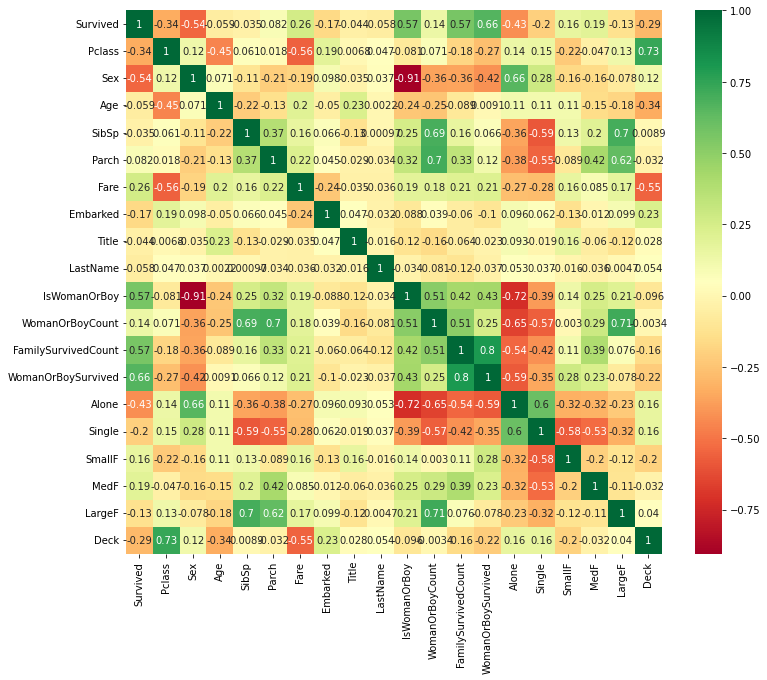

In [9]:
'''
Interpretting the data: 
Green and rating close to 1 == multicolinarity (they contain basically the same information)
Red and close to -1 means: 
'''
def feature_correlation(df):
    #Using Pearson Correlation
    plt.figure(figsize=(12,10))
    cor = df.corr()
    sns.heatmap(cor, annot=True, cmap='RdYlGn')
    plt.show()
feature_correlation(df)

### To CSV

In [10]:
def create_preprocessed_csv():
    train_data.to_csv("processed_train.csv")
    test_data.to_csv("processed_test.csv")

# create_preprocessed_csv()


<AxesSubplot:ylabel='PassengerId'>

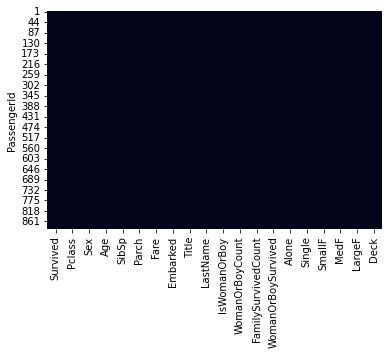

In [11]:
train_data.columns[train_data.isna().any()].tolist()
train_data[train_data['Embarked'].isna() == True]
#train_data['Embarked']
#test_data.columns[test_data.isna().any()].tolist()
# visualization of missing entitires
sns.heatmap(train_data.isnull(),cbar=False)

## Keeping track of models

For now we will keep a dictionary with all the models performance

Model will map to (fnr, fpr)

Next we will pickle them so we don't have to waste time retraining

In [12]:
'''
Use this method to score the cross evaluation
This way we will have the confusion matrix values for each fold and we can easily get the average fnr and fpr
'''
def confusion_matrix_scorer(clf, X, y):
    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    accuracy = clf.score(X, y)
    return {'tn': cm[0, 0], 'fp': cm[0, 1],
            'fn': cm[1, 0], 'tp': cm[1, 1], "acc": accuracy}

# fit and evaluate model
def eval(model):
    # cross validation --> generate different train test splits
    
    cv = KFold(n_splits=5)

    model.fit(X_train.values, y_train.values)

    # cross eval accuracy
    score = cross_validate(model, X_train.values, y_train.values, cv = cv, scoring=confusion_matrix_scorer)
    print(score)

    tn = np.mean(score['test_tn'])
    fp = np.mean(score['test_fp'])
    fn = np.mean(score['test_fn'])
    tp = np.mean(score['test_tp'])
    acc = np.mean(score['test_acc'])

    print("Accuracy", acc)
    print("")
    print("True Negatives", tn)
    print("False Positives", fp)
    print("False Negatives", fn)
    print("True Positives", tp)
    print("")
    fpr = fp / (fp + tn)
    print("FPR", fpr)
    fnr = fn / (fn + tp)
    print("FNR", fnr)
    models[type(model).__name__] = (fpr, fnr)

In [13]:
# visualization that plots the training curve, vs the validatoin curve (buggy)
def overfitting_vis(model):
    params = model.get_params()
    print("Parameters")
    print(params)
    param_range = np.logspace(-6, -1, 5)
    for key, val in params.items():
        if type(val) != int:
            continue
        print("Validation with param:", key)
        train_scores, test_scores = validation_curve(model,
                                                     X_train, y_train, param_name=key, param_range=param_range, cv=5, scoring=make_scorer(matthews_corrcoef))
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        title = "Validation Curve with" + str(type(model).__name__)
        plt.title(title)
        plt.xlabel("Param being tuned")
        plt.ylabel("MCC")
        plt.ylim(0.0, 1.1)
        lw = 2
        plt.semilogx(train_scores_mean, label="Training score",
                     color="darkorange", lw=lw)
        plt.fill_between(train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.2,
                         color="darkorange", lw=lw)
        plt.semilogx(test_scores_mean, label="Cross-validation score",
                     color="navy", lw=lw)
        plt.fill_between(test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.2,
                         color="navy", lw=lw)
        plt.legend(loc="best")
        plt.show()

In [14]:
'''
Hypothesis testing for nonparametric tests
Mann-whiney U test must be on independent samples
Wilcoxon Signed-Rank Test --> datasamples are paired, not independent
'''
def hypoth_test():
    stat, p = wilcoxon(data1, data2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

### Hashmap to keep track of models
{model_name: (fpr, fnr)}

In [15]:
models = {}

## Tree

In [16]:
tree_clf = tree.DecisionTreeClassifier()
eval(tree_clf)

# overfitting vis is buggy
# overfitting_vis(tree_clf)

{'fit_time': array([0.00139284, 0.00139427, 0.00139761, 0.00136614, 0.00137997]), 'score_time': array([0.00071025, 0.00037599, 0.00035834, 0.00036812, 0.00039506]), 'test_tn': array([95, 86, 96, 95, 94]), 'test_fp': array([25, 13, 13, 11, 21]), 'test_fn': array([ 9, 14, 13, 20, 10]), 'test_tp': array([50, 65, 56, 52, 53]), 'test_acc': array([0.81005587, 0.84831461, 0.85393258, 0.8258427 , 0.8258427 ])}
Accuracy 0.8327976900382901

True Negatives 93.2
False Positives 16.6
False Negatives 13.2
True Positives 55.2

FPR 0.151183970856102
FNR 0.19298245614035084


## KNN

In [17]:
knn_clf = neighbors.KNeighborsClassifier()
eval(knn_clf)

{'fit_time': array([0.00083899, 0.00022912, 0.00063896, 0.00022578, 0.00019598]), 'score_time': array([0.03322697, 0.02839494, 0.01483321, 0.01309228, 0.00704384]), 'test_tn': array([113,  97, 105, 103, 113]), 'test_fp': array([7, 2, 4, 3, 2]), 'test_fn': array([12, 17, 16, 26, 15]), 'test_tp': array([47, 62, 53, 46, 48]), 'test_acc': array([0.89385475, 0.89325843, 0.88764045, 0.83707865, 0.90449438])}
Accuracy 0.8832653317431423

True Negatives 106.2
False Positives 3.6
False Negatives 17.2
True Positives 51.2

FPR 0.03278688524590164
FNR 0.25146198830409355


## NN

In [18]:
NN_clf = neural_network.MLPClassifier()
eval(NN_clf)

/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

{'fit_time': array([0.33548999, 0.37461877, 0.37920165, 0.39500308, 0.48109007]), 'score_time': array([0.00171375, 0.00167608, 0.00362825, 0.00181794, 0.00168705]), 'test_tn': array([116,  95, 105, 106, 113]), 'test_fp': array([4, 4, 4, 0, 2]), 'test_fn': array([12, 15, 17, 28, 13]), 'test_tp': array([47, 64, 52, 44, 50]), 'test_acc': array([0.91061453, 0.89325843, 0.88202247, 0.84269663, 0.91573034])}
Accuracy 0.8888644780616408

True Negatives 107.0
False Positives 2.8
False Negatives 17.0
True Positives 51.4

FPR 0.025500910746812384
FNR 0.24853801169590642


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## SVM

In [19]:
svm_clf = svm.SVC(kernel='linear')
eval(svm_clf)

{'fit_time': array([0.01154613, 0.0103879 , 0.00440288, 0.01408911, 0.01237607]), 'score_time': array([0.00513196, 0.0014081 , 0.00125599, 0.00375104, 0.00373101]), 'test_tn': array([119,  96, 108, 106, 114]), 'test_fp': array([1, 3, 1, 0, 1]), 'test_fn': array([12, 16, 18, 29, 13]), 'test_tp': array([47, 63, 51, 43, 50]), 'test_acc': array([0.9273743 , 0.89325843, 0.89325843, 0.83707865, 0.92134831])}
Accuracy 0.8944636243801394

True Negatives 108.6
False Positives 1.2
False Negatives 17.6
True Positives 50.8

FPR 0.01092896174863388
FNR 0.2573099415204678


In [20]:
svm_linear = svm.LinearSVC()
eval(svm_linear)

{'fit_time': array([0.00512505, 0.00517297, 0.00816989, 0.00775909, 0.00516295]), 'score_time': array([0.00038099, 0.00032902, 0.00032282, 0.00031114, 0.00031114]), 'test_tn': array([114,  94, 106, 105, 112]), 'test_fp': array([6, 5, 3, 1, 3]), 'test_fn': array([13, 13, 15, 27, 11]), 'test_tp': array([46, 66, 54, 45, 52]), 'test_acc': array([0.89385475, 0.8988764 , 0.8988764 , 0.84269663, 0.92134831])}
Accuracy 0.8911305002824681

True Negatives 106.2
False Positives 3.6
False Negatives 15.8
True Positives 52.6

FPR 0.03278688524590164
FNR 0.2309941520467836


## Linear

In [21]:
logistic = linear_model.LogisticRegression()
eval(logistic)

{'fit_time': array([0.01111794, 0.00415206, 0.01390791, 0.00478673, 0.00411487]), 'score_time': array([0.00039506, 0.00034118, 0.00103593, 0.00033522, 0.00032687]), 'test_tn': array([114,  95, 107, 104, 112]), 'test_fp': array([6, 4, 2, 2, 3]), 'test_fn': array([13, 14, 15, 26, 12]), 'test_tp': array([46, 65, 54, 46, 51]), 'test_acc': array([0.89385475, 0.8988764 , 0.90449438, 0.84269663, 0.91573034])}
Accuracy 0.8911305002824681

True Negatives 106.4
False Positives 3.4
False Negatives 16.0
True Positives 52.4

FPR 0.030965391621129323
FNR 0.23391812865497075


In [22]:
perceptron = linear_model.Perceptron()
eval(perceptron)

{'fit_time': array([0.00176191, 0.00153422, 0.00174904, 0.00056815, 0.00058699]), 'score_time': array([0.00122404, 0.00101376, 0.0004828 , 0.00032783, 0.000319  ]), 'test_tn': array([ 97,  73, 106, 101, 110]), 'test_fp': array([23, 26,  3,  5,  5]), 'test_fn': array([12, 12, 15, 25, 10]), 'test_tp': array([47, 67, 54, 47, 53]), 'test_acc': array([0.80446927, 0.78651685, 0.8988764 , 0.83146067, 0.91573034])}
Accuracy 0.8474107086811877

True Negatives 97.4
False Positives 12.4
False Negatives 14.8
True Positives 53.6

FPR 0.11293260473588342
FNR 0.21637426900584794


In [23]:
ridge = linear_model.RidgeClassifier()
eval(ridge)

{'fit_time': array([0.00079989, 0.00063586, 0.00061512, 0.00060678, 0.0031569 ]), 'score_time': array([0.00035405, 0.00032902, 0.00031805, 0.000319  , 0.0003171 ]), 'test_tn': array([112,  94, 107, 104, 111]), 'test_fp': array([8, 5, 2, 2, 4]), 'test_fn': array([13, 14, 15, 26, 12]), 'test_tp': array([46, 65, 54, 46, 51]), 'test_acc': array([0.88268156, 0.89325843, 0.90449438, 0.84269663, 0.91011236])}
Accuracy 0.8866486723997238

True Negatives 105.6
False Positives 4.2
False Negatives 16.0
True Positives 52.4

FPR 0.03825136612021858
FNR 0.23391812865497075


In [24]:
sdg = linear_model.SGDClassifier()
eval(sdg)

{'fit_time': array([0.00356269, 0.00121498, 0.00186205, 0.00137401, 0.00148082]), 'score_time': array([0.00044322, 0.00032902, 0.00031185, 0.00030899, 0.00030804]), 'test_tn': array([110,  92, 107, 106, 105]), 'test_fp': array([10,  7,  2,  0, 10]), 'test_fn': array([11, 13, 15, 29, 10]), 'test_tp': array([48, 66, 54, 43, 53]), 'test_acc': array([0.88268156, 0.88764045, 0.90449438, 0.83707865, 0.88764045])}
Accuracy 0.8799070993660159

True Negatives 104.0
False Positives 5.8
False Negatives 15.6
True Positives 52.8

FPR 0.052823315118397086
FNR 0.2280701754385965


## Ensemble

In [25]:
random_forest = ensemble.RandomForestClassifier()
eval(random_forest)

{'fit_time': array([0.09502792, 0.05783486, 0.05840421, 0.05827928, 0.05834389]), 'score_time': array([0.00789714, 0.00744104, 0.00756001, 0.00750589, 0.00747013]), 'test_tn': array([112,  95, 104, 106, 110]), 'test_fp': array([8, 4, 5, 0, 5]), 'test_fn': array([10, 15, 12, 25, 10]), 'test_tp': array([49, 64, 57, 47, 53]), 'test_acc': array([0.89944134, 0.89325843, 0.90449438, 0.85955056, 0.91573034])}
Accuracy 0.8944950097294584

True Negatives 105.4
False Positives 4.4
False Negatives 14.4
True Positives 54.0

FPR 0.04007285974499089
FNR 0.21052631578947367


In [26]:
gradient_boost = ensemble.GradientBoostingClassifier()
eval(gradient_boost)

{'fit_time': array([0.06318188, 0.06253791, 0.06284785, 0.06257296, 0.06241989]), 'score_time': array([0.00093222, 0.00082684, 0.00084925, 0.00081015, 0.00080204]), 'test_tn': array([113,  95, 107, 103, 107]), 'test_fp': array([7, 4, 2, 3, 8]), 'test_fn': array([11, 14, 13, 25, 10]), 'test_tp': array([48, 65, 56, 47, 53]), 'test_acc': array([0.89944134, 0.8988764 , 0.91573034, 0.84269663, 0.8988764 ])}
Accuracy 0.8911242232126042

True Negatives 105.0
False Positives 4.8
False Negatives 14.6
True Positives 53.8

FPR 0.04371584699453552
FNR 0.21345029239766083


In [27]:
extra_trees = ensemble.ExtraTreesClassifier()
eval(extra_trees)

{'fit_time': array([0.04678702, 0.04591584, 0.04638481, 0.0451901 , 0.04621792]), 'score_time': array([0.00813818, 0.00805712, 0.00813603, 0.00813389, 0.00820398]), 'test_tn': array([112,  93, 104, 102, 110]), 'test_fp': array([8, 6, 5, 4, 5]), 'test_fn': array([ 9, 16, 15, 24,  9]), 'test_tp': array([50, 63, 54, 48, 54]), 'test_acc': array([0.90502793, 0.87640449, 0.88764045, 0.84269663, 0.92134831])}
Accuracy 0.8866235641202687

True Negatives 104.2
False Positives 5.6
False Negatives 14.6
True Positives 53.8

FPR 0.05100182149362477
FNR 0.21345029239766083


In [28]:
bagging = ensemble.BaggingClassifier()
eval(bagging)

{'fit_time': array([0.01219511, 0.01140499, 0.01145101, 0.01127005, 0.01126504]), 'score_time': array([0.00127912, 0.00117898, 0.00116777, 0.00116301, 0.00117183]), 'test_tn': array([111,  94, 107, 105, 107]), 'test_fp': array([9, 5, 2, 1, 8]), 'test_fn': array([ 9, 16, 15, 21, 13]), 'test_tp': array([50, 63, 54, 51, 50]), 'test_acc': array([0.89944134, 0.88202247, 0.90449438, 0.87640449, 0.88202247])}
Accuracy 0.8888770322013684

True Negatives 104.8
False Positives 5.0
False Negatives 14.8
True Positives 53.6

FPR 0.04553734061930784
FNR 0.21637426900584794


## Random Forest

In [29]:
random_forest = GridSearchCV(estimator=ensemble.RandomForestClassifier(), param_grid={'n_estimators': [200, 300, 400, 500]}, cv=10).fit(X_train, y_train)
random_forest.fit(X_train, y_train)
acc = random_forest.score(X_train, y_train)
# find best paremeters
# print(acc,random_forest.best_params_)

random_forest = ensemble.RandomForestClassifier(n_estimators = 500)
eval(random_forest)

{'fit_time': array([0.29007101, 0.28582096, 0.29125309, 0.28660321, 0.29013681]), 'score_time': array([0.0369091 , 0.0353241 , 0.03586721, 0.03605866, 0.03601313]), 'test_tn': array([113,  93, 105, 105, 110]), 'test_fp': array([7, 6, 4, 1, 5]), 'test_fn': array([10, 15, 12, 25, 10]), 'test_tp': array([49, 64, 57, 47, 53]), 'test_acc': array([0.90502793, 0.88202247, 0.91011236, 0.85393258, 0.91573034])}
Accuracy 0.8933651371539766

True Negatives 105.2
False Positives 4.6
False Negatives 14.4
True Positives 54.0

FPR 0.0418943533697632
FNR 0.21052631578947367


## XGB

In [30]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    current_score = cross_val_score(clf, X_train, y_train, cv=10).mean()
    print(current_score, params)
    return current_score 

# space_xgb = {
#             'learning_rate': hp.quniform('learning_rate', 0, 0.05, 0.0001),
#             'n_estimators': hp.choice('n_estimators', range(100, 1000)),
#             'max_depth':  hp.choice('max_depth', np.arange(5, 8, dtype=int)),
#             'min_child_weight': hp.quniform('min_child_weight', 1, 9, 0.025),
#             'subsample': hp.quniform('subsample', 0.5, 1, 0.005),
#             'gamma': hp.quniform('gamma', 0.5, 1, 0.005),
#             'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.005),
#             'eval_metric': 'auc',
#             'objective': 'binary:logistic',
#             'booster': 'gbtree',
#             'tree_method': 'exact',
#             'silent': 1,
#             'missing': None
#         }

# best = fmin(fn=hyperopt_xgb_score, space=space_xgb, algo=tpe.suggest, max_evals=10)

# params = space_eval(space_xgb, best)

xgb_clf = XGBClassifier()
# xgb_clf.fit(X_train, y_train)
# acc = xgb_clf.score(X_train, y_train)
# print("Accuracy", acc)
eval(xgb_clf)

{'fit_time': array([0.04606104, 0.03910089, 0.04010391, 0.05255342, 0.04056025]), 'score_time': array([0.00149679, 0.00163603, 0.00170398, 0.00166464, 0.00159264]), 'test_tn': array([112,  90,  99, 102, 108]), 'test_fp': array([ 8,  9, 10,  4,  7]), 'test_fn': array([ 9, 13, 11, 24,  9]), 'test_tp': array([50, 66, 58, 48, 54]), 'test_acc': array([0.90502793, 0.87640449, 0.88202247, 0.84269663, 0.91011236])}
Accuracy 0.8832527776034148

True Negatives 102.2
False Positives 7.6
False Negatives 13.2
True Positives 55.2

FPR 0.0692167577413479
FNR 0.19298245614035084


In [31]:
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def show_matrix(model):
    y_pred = model.cross_validate_predict(X)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_truth, y_pred)
    class_names=['0', '1']
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                        title='Confusion matrix, without normalization')

    plt.show()

#  show_matrix(knn_clf)

In [32]:
def create_pred_csv(model):
    predictions = model.predict(test_data.values).astype(int)
    pred_df = pd.DataFrame(predictions, index=test_data.index, columns=['Survived'])
    type(pred_df)
    pred_df.to_csv(type(model).__name__ + 'predictions.csv', header=True, sep=',')


# think the test_data has NaN so it really doesn't like it
create_pred_csv(tree_clf)

### Nathan's Pareto Frontier code

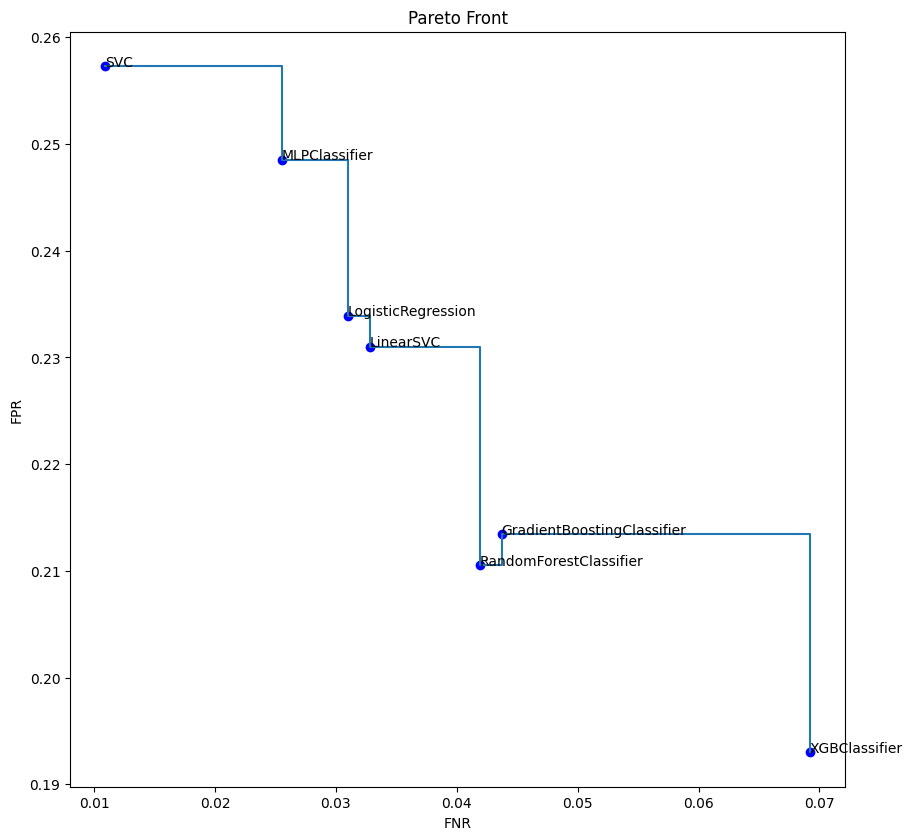

In [38]:
def pareto_frontier(models):
    dominated = []
    pareto = []
    for model in models:
        fnr, fpr = models[model]
        if pareto:
            classified = False
            for curr_model in pareto:
                curr_fnr, curr_fpr = models[curr_model]
                if (curr_fnr <= fnr and curr_fpr < fpr) or (curr_fnr < fnr and curr_fpr <= fpr):
                    dominated.append(model)
                    classified = True
                elif (curr_fnr >= fnr and curr_fpr > fpr) or (curr_fnr > fnr and curr_fpr >= fpr):
                    dominated.append(curr_model)
                    pareto.remove(curr_model)
            if not classified:
                pareto.append(model)
        else:
            pareto.append(model)
                
    fnr = []
    fpr = []
    for model in pareto:
        cfnr, cfpr = models[model]
        i = 0
        while i < len(fnr):
            if cfnr > fnr[i]:
                i += 1
            else:
                break
        fnr.insert(i, cfnr)
        fpr.insert(i, cfpr)

    plt.figure(figsize=(10, 10), dpi=100)
    plt.step(fnr, fpr, where='post', label = 'post')
    for model in pareto:
        curr_fnr, curr_fpr = models[model]
        plt.scatter(curr_fnr, curr_fpr, color='b')
        plt.annotate(str(model), (curr_fnr, curr_fpr))
    plt.xlabel("FNR")
    plt.ylabel("FPR")
    plt.title("Pareto Front")
    return pareto
pareto = pareto_frontier(models)

## Function to display pareto front

We will give it the model dict and all the fpr and fnr that we have

https://oapackage.readthedocs.io/en/latest/examples/example_pareto.html

https://stackoverflow.com/questions/21294829/fast-calculations-of-the-pareto-front-in-r

The trick here is to sort by x, which then allows you to limit your check to making sure that all prior values of x must have greater values of y to ensure that point is on the frontier.

In [39]:
def create_models_df(models):
    df = pd.DataFrame(columns = ['model', 'fpr', 'fnr'])
    for model in models:
        fpr, fnr = models[model]
        df.loc[len(df.index)] = [model, fpr, fnr]
    return df

def find_hof(df):
    out = {}
    for index, row in df.iterrows():
        # look at all the models with a higher fpr
        tmp = df[df.fpr < row['fpr']]
        # drop the ones with a higher fnr
        tmp = tmp[tmp.fnr <= row['fnr']]
        # not optimal
        if len(tmp)  == 0:
            model = row['model']
            fpr = row['fpr']
            fnr = row['fnr']
            out[model] = (fpr, fnr)
    return out


df = create_models_df(models)
hof = find_hof(df)
print(hof)


{'MLPClassifier': (0.025500910746812384, 0.24853801169590642), 'SVC': (0.01092896174863388, 0.2573099415204678), 'LinearSVC': (0.03278688524590164, 0.2309941520467836), 'LogisticRegression': (0.030965391621129323, 0.23391812865497075), 'RandomForestClassifier': (0.0418943533697632, 0.21052631578947367), 'XGBClassifier': (0.0692167577413479, 0.19298245614035084)}


In [43]:
# comparison between by HOF and Nathans
def equals(nathans, mine):
    n = set(nathans)
    m = set(mine.keys())
    if n == m:
        return "They are the same"
    else:
        print('Tristans set', m)
        print('Nathan set', n)
        return "They are not the same"

print(equals(pareto, hof))

# Area under the curve calculation
def auc(hof):
    area = 0
    hof = sorted(hof.values(), key=lambda x: x[0])
    prev_x, prev_y = 0, 1
    for new_x, new_y in hof:
        area += (new_x - prev_x) * (prev_y - new_y)
        prev_x, prev_y = new_x, new_y
    return area
            
auc(hof)

Tristans set {'RandomForestClassifier', 'LogisticRegression', 'XGBClassifier', 'LinearSVC', 'MLPClassifier', 'SVC'}
Nathan set {'RandomForestClassifier', 'LogisticRegression', 'XGBClassifier', 'LinearSVC', 'MLPClassifier', 'GradientBoostingClassifier', 'SVC'}
They are not the same


0.008995622024094848